In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found. Make sure your GPU is properly installed and configured.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully.")

GPU configured successfully.


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate GPU memory growth
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [4]:
import tensorflow as tf

# Check if TensorFlow can access GPU
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))

if num_gpus > 0:
    print("Num GPUs Available: ", num_gpus)
    print("TensorFlow is using GPU.")
else:
    print("No GPU available. TensorFlow is using CPU.")

Num GPUs Available:  1
TensorFlow is using GPU.


In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image,tf.float32)
    return image

In [6]:
path = "/kaggle/input/monumentimagenotaugmented/"
x = load(os.path.join(path, 'train/Train_3221.jpg'))
print(x.shape)

(300, 300, 3)


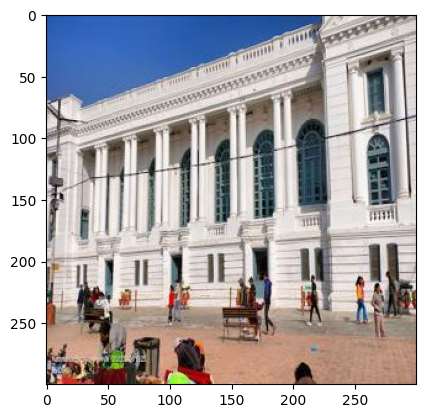

In [7]:
plt.imshow(x/255.0)

In [8]:
def normalize(real_image):
    real_image = (real_image / 255)
    return real_image

In [9]:
def random_crop(real_image):
    cropped_image = tf.image.random_crop(real_image, size = [256, 256, 3])
    return cropped_image

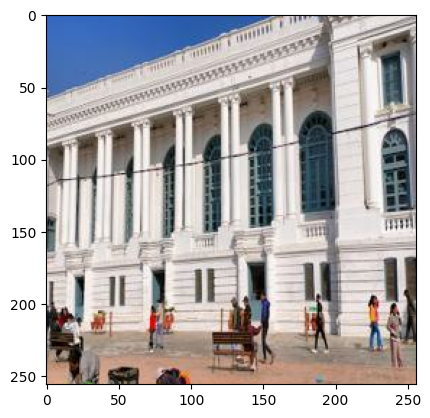

In [10]:
x_aug = random_crop(x)
plt.imshow(x_aug/255.0)

In [11]:
def resize(real_image):
    real_image = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image

In [12]:
def rotate_image(image, angles, interpolation='BILINEAR'):
    """
    Rotate an image tensor by specified angles.

    Args:
    - image: Input image tensor with shape (batch_size, height, width, channels).
    - angles: Tensor of rotation angles in radians for each image in the batch.
    - interpolation: Interpolation method ('BILINEAR' or 'NEAREST').

    Returns:
    - Rotated image tensor.
    """
    batch_size, height, width, channels = tf.unstack(tf.shape(image))

    # Coordinates of the center of the image
    center_x = tf.cast(width, tf.float32) / 2.0
    center_y = tf.cast(height, tf.float32) / 2.0

    # Define transformation matrix
    rotation_matrix = tf.reshape(tf.stack([tf.cos(angles), -tf.sin(angles), center_x * (1 - tf.cos(angles)) + center_y * tf.sin(angles),
                                           tf.sin(angles), tf.cos(angles), -center_x * tf.sin(angles) + center_y * (1 - tf.cos(angles)),
                                           0.0, 0.0, 1.0], axis=1), shape=(-1, 3, 3))

    # Apply rotation to each pixel
    rotated_image = tfa.image.transform(image, rotation_matrix, interpolation)

    return rotated_image


In [13]:
def random_jitter(real_image):
    if tf.random.uniform(()) > 0.5:
        real_image = tf.image.flip_left_right(real_image)
    return real_image

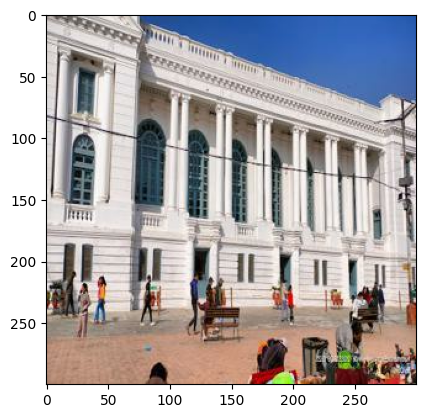

In [14]:
x_jitter = random_jitter(x)
plt.imshow(x_jitter/255.0)

In [15]:
def load_train_images(image_path):
    real_image = load(image_path)
    real_image = tf.image.random_brightness(real_image, 0.2)
    real_image = random_crop(real_image)
    # Define the rotation angle in radians
    rotation_angle = tf.constant(20.0 * (3.141592653589793 / 180.0), dtype=tf.float32)

    # Apply the rotation using tfa.image.rotate
    real_image = tfa.image.rotate(real_image, angles=rotation_angle)

#     # Example usage
#     angles = tf.placeholder(dtype=tf.float32, shape=(None,))
#     # Specify the rotation range in degrees
#     rotation_range = 15  # Adjust this value as needed
#     # Convert the rotation range to radians
#     rotation_range_rad = rotation_range * (np.pi / 180.0)
#     # Generate random rotation angles for each image in the batch
#     random_angles = tf.random.uniform(shape=(tf.shape(image)[0],), minval=-rotation_range_rad, maxval=rotation_range_rad)
#     # Apply custom rotation to the image with bilinear interpolation
#     real_image = rotate_image(real_image, random_angles, interpolation='BILINEAR')
    #     real_image = rotate(real_image)
    real_image = random_jitter(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [16]:
def load_test_image(image_path):
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 8

In [18]:
# create input pipeline
train_dataset = tf.data.Dataset.list_files(path + "train/*.jpg")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [19]:
validation_dataset = tf.data.Dataset.list_files(path + 'val/*.jpg')
validation_dataset = validation_dataset.map(load_test_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [20]:
test_dataset = tf.data.Dataset.list_files(path + 'test/*.jpg')
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [21]:
# downsample block
def downsample(filters, size,dropout=False, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
    if dropout == True :
        result.add(Dropout(0.3))
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)

(1, 150, 150, 3)


In [22]:
# upsample block
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.3))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 300, 300, 3)


In [23]:
def generator(input_shape = (256,256,1), output_channels = 2):
    inputs = Input(shape = input_shape)
    down_stack = [
        downsample(32, 4, batchnorm=False),
        downsample(32, 4),
        downsample(64, 4),
        downsample(64, 4, dropout = True),
        downsample(128, 4, dropout = True),
        downsample(256, 4, dropout = True),
        downsample(512, 4, dropout = True),
        downsample(512, 4, dropout = True)
    ]


    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(256, 4, dropout=True),
        upsample(128, 4, dropout=True),
        upsample(64, 4, dropout=True),
        upsample(64, 4, dropout=True),
        upsample(32, 4),
        upsample(32, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(2, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs = inputs, outputs = x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128, 128, 32)         512       ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 32)           16512     ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 64)           33024     ['sequential_3[0][0]']        
                                                                                              

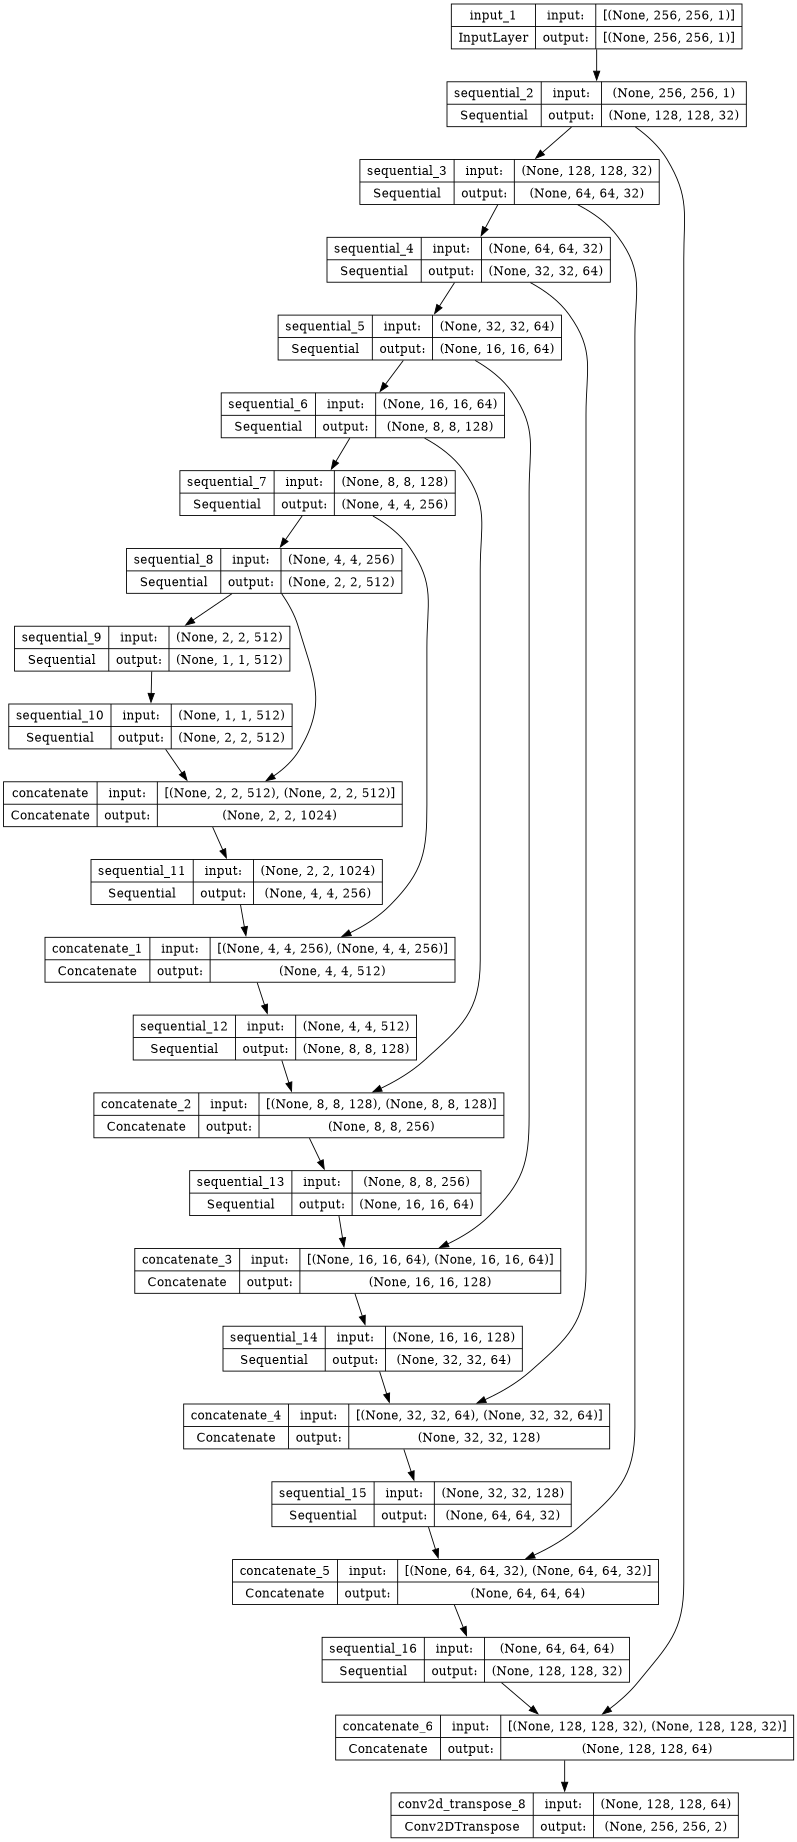

In [24]:
gen = generator()
gen.summary()
plot_model(gen, show_shapes=True, dpi = 64)

In [25]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 1], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 2], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

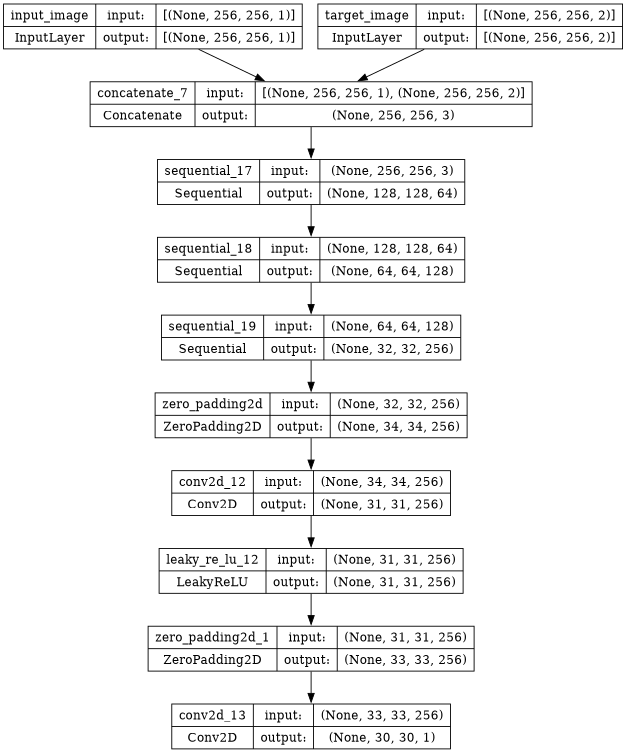

In [26]:
disc = discriminator()
plot_model(disc, show_shapes=True, dpi = 64)

In [27]:
# Function to create YUV image from Y, U, and V channels and then convert to rgb
def create_rgb_image(y_channel, uv_channel):
    # Assuming YUV format where Y, U, and V channels are separate
    # y_channel = np.array(y_channel)
    # uv_channel = np.array(uv_channel)
    u_channel, v_channel = tf.split(uv_channel, num_or_size_splits=2, axis=-1)

    # Combine Y, U, and V channels into a YUV image
    rgb_image = tf.image.yuv_to_rgb(tf.concat([y_channel, u_channel, v_channel], axis=-1))
    return rgb_image


In [28]:
LAMBDA = 30

In [29]:
# Define the perceptual loss function
def perceptual_loss(y_true, y_pred):
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
    vgg.trainable = False
    for layer in vgg.layers:
        layer.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    model.trainable = False

    y_true_features = model(y_true)
    y_pred_features = model(y_pred)

    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

In [30]:
def generator_loss(disc_generated_output,input_, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    p_loss = perceptual_loss(create_rgb_image(input_, gen_output), create_rgb_image(input_, target))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + 50*p_loss
    return total_gen_loss, gan_loss, l1_loss, p_loss

In [31]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [32]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss, real_loss, generated_loss

In [33]:
generator_optimizer = Adam(lr= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

In [34]:
epochs = 250

In [35]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load the VGG19 model
vgg = VGG19(weights='imagenet', include_top=False)

# Select the layers you want to use for the LPIPS score
selected_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']

# Create a model that outputs the selected layers
outputs = [vgg.get_layer(name).output for name in selected_layers]
model = Model(inputs=vgg.input, outputs=outputs)

# Make sure the VGG model is not trainable
model.trainable = False

def lpips_score(image1, image2):
    # Get the features for both images
    image1_features = model(image1)
    image2_features = model(image2)

    # Initialize the score
    score = 0

    # For each feature layer...
    for f1, f2 in zip(image1_features, image2_features):
        # ... compute the mean squared error between the features
        mse = tf.reduce_mean((f1 - f2)**2)
        # ... and add it to the score
        score += mse

    return score

80134624/80134624 [==============================] - 0s 0us/step


In [36]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

# Load the pre-trained InceptionV3 model (weights will be downloaded if not present)
pretrained_model = InceptionV3(weights='imagenet', include_top=True, pooling='avg')

# Optionally, you can freeze the layers to prevent training
for layer in pretrained_model.layers:
    layer.trainable = False


# Create a new model to extract features from an intermediate layer
inception_model = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('avg_pool').input)
def calculate_fid_score(images1, images2, inception_model):
    # Ensure the batch dimension is removed for individual image predictions
    images1 = np.squeeze(images1, axis=0)
    images2 = np.squeeze(images2, axis=0)
    
    # Resize images to the required size for the Inception model
    images1 = tf.image.resize(images1, size=(299, 299))
    images2 = tf.image.resize(images2, size=(299, 299))
    
    # Extract features using the Inception model
    features1 = inception_model.predict(np.expand_dims(images1, axis=0))
    features2 = inception_model.predict(np.expand_dims(images2, axis=0))

    # Remove batch dimension from features
    features1 = np.squeeze(features1, axis=0)
    features2 = np.squeeze(features2, axis=0)
    #print(features1.shape)
    # Calculate mean and covariance of feature representations
    mean1 = np.mean(features1, axis=(0, 1, 2))
    mean2 = np.mean(features2, axis=(0, 1, 2))
    #print(features1.shape)
    cov1 = np.cov(features1.transpose(2, 0, 1).reshape(features1.shape[-1], -1), rowvar=False)
    cov2 = np.cov(features2.transpose(2, 0, 1).reshape(features2.shape[-1], -1), rowvar=False)
    #print(cov2.shape)

    # Calculate the squared Euclidean distance between means
    sum_squared_diff = np.sum((mean1 - mean2)**2)

    # Calculate the trace of the product of covariances
    cov_sqrt = sqrtm(np.dot(cov1, cov2))
    trace_cov_product = np.trace(cov1 + cov2 - 2 * cov_sqrt)

    # Calculate FID score
    fid_score = np.real(sum_squared_diff + trace_cov_product)
    
    return fid_score

96112376/96112376 [==============================] - 0s 0us/step


In [37]:
@tf.function
def train_step(input_image, target, epoch, training_discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training=True)
        disc_real_output = disc([input_image, target], training=True)
        disc_generated_output = disc([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
        disc_loss, disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
        rgb_target = create_rgb_image(input_image, target)
        rgb_generated = create_rgb_image(input_image, gen_output)
        ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
        psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
        lpips_values = lpips_score(rgb_target, rgb_generated)

        if epoch > 8:
            if training_discriminator:
                discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
            else:
                generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
                generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        else:
            generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
            generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values

In [38]:
@tf.function
def validation_step(input_image, target):
    # Generate output using the generator
    gen_output = gen(input_image)

    # Calculate losses without updating gradients
    disc_real_output = disc([input_image, target])
    disc_generated_output = disc([input_image, gen_output])

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
    disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
    rgb_target = create_rgb_image(input_image, target)
    rgb_generated = create_rgb_image(input_image, gen_output)
    ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
    psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
    lpips_values = lpips_score(rgb_target, rgb_generated)
    #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values

In [39]:
@tf.function
def test_step(input_image, target):
    # Generate output using the generator
    gen_output = gen(input_image)

    # Calculate losses without updating gradients
    disc_real_output = disc([input_image, target])
    disc_generated_output = disc([input_image, gen_output])

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
    disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
    rgb_target = create_rgb_image(input_image, target)
    rgb_generated = create_rgb_image(input_image, gen_output)
    ssim_values = tf.image.ssim(rgb_target, rgb_generated, max_val=1.0)
    psnr_values = tf.image.psnr(rgb_target, rgb_generated, max_val=1.0)
    lpips_values = lpips_score(rgb_target, rgb_generated)
    fid_values = calculate_fid_score(rgb_target, rgb_generated, inception_model)
    #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values, fid_values


In [40]:
os.mkdir('/kaggle/working/gen_output/')

In [41]:
def display_one_random_test_image(input_, target, gen_model, epoch):
    print("Displaying one random test image...")
    img_array = np.array(input_)
    generated_output_test = gen_model(input_)
    ssim = tf.image.ssim(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)
    psnr = tf.image.psnr(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)  
    lpips = lpips_score(tf.reshape(create_rgb_image(input_, target), (1,256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1,256,256,3)))
    p_loss = perceptual_loss(create_rgb_image(input_, target), create_rgb_image(input_, generated_output_test))
    fid_score = calculate_fid_score(tf.reshape(create_rgb_image(input_, target), (1,256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1,256,256,3)), inception_model)
    # print(input_.shape)
    input_ = np.squeeze(input_, axis=0)
    # print(type(input_), type(target))
    # print(input_.shape, input_)
    # input_.reshape((256,256))
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 4, 1)
    plt.title('Input Testing Image')
    plt.imshow(input_, cmap='gray', vmax = 1, vmin = 0)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # print(target.shape)
    target = np.squeeze(target, axis=0)
    # # print(target.shape)
    target_img = create_rgb_image(input_, target).numpy()
    # # print(type(target_img))
    # target
    # # print(target_img.shape, target_img)
    plt.subplot(1, 4, 2)
    plt.title('Target Testing Image')
    plt.imshow(target_img)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # Convert PIL Image to NumPy array
    # img_array = np.array(input_)
    # # Add batch dimension
    # # print(img_array.shape)
    # img_array = np.expand_dims(img_array, axis=0)
    # # print(img_array.shape)
    # generated_output_test = gen_model(img_array)
    # # print(generated_output_test.shape)
    # # Squeeze the singleton dimension
    generated_output_test = np.squeeze(generated_output_test, axis=0)
    # # print(generated_output_test.shape)
    generated_img = create_rgb_image(input_, generated_output_test).numpy()
    # # print(generated_img.shape, generated_img)
    plt.subplot(1, 4, 3)
    plt.title(f'Generated Output -- epoch {epoch}')
    plt.imshow(generated_img)  # Assuming images are normalized to [-1, 1]
    plt.axis('off')
    plt.savefig(f'/kaggle/working/gen_output/epoch_{epoch}.png')
    plt.show()
    print('SSIM Score: {}'.format(ssim))
    print('PSNR Score: {}'.format(psnr))
    print('LPIPS Score: {}'.format(lpips))
    print('Perceptual Loss: {}'.format(p_loss))
    print('FID Score: {}'.format(fid_score))

In [42]:
def display_random_test_image(gen_model, image_path, epoch):
    
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:] 

    # Display the image
    display_one_random_test_image(tf.reshape(Y_channel, (1,256,256,1)),tf.reshape(UV_channels,(1,256,256,2)), gen_model, epoch)


Displaying one random test image...
1/1 [==============================] - 0s 25ms/step


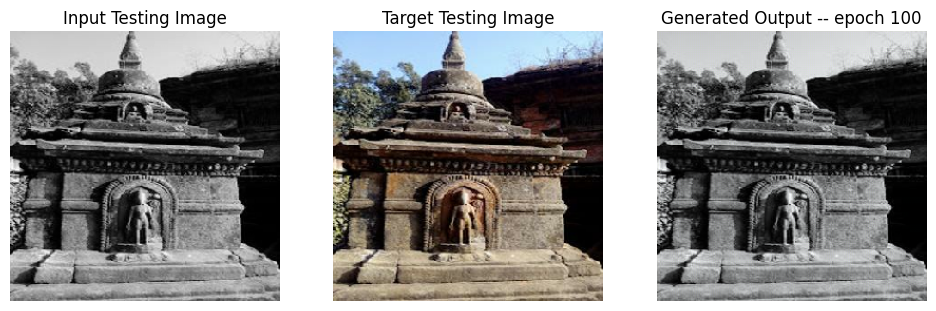

SSIM Score: 0.9573639035224915
PSNR Score: 24.16297721862793
LPIPS Score: 0.5566616058349609
Perceptual Loss: 0.009229205548763275
FID Score: 0.6153443275255532


In [43]:
display_random_test_image(gen, '/kaggle/input/monumentimagenotaugmented/val/Val_1020.jpg',100)

In [44]:
import random

each_epoch_train_generator_losses = []
each_epoch_train_generator_gan_losses = []
each_epoch_train_generator_l1_losses = []
each_epoch_train_generator_l2_losses = []
each_epoch_train_generator_perceptual_losses = []
each_epoch_train_discriminator_losses = []
each_epoch_train_discriminator_real_losses = []
each_epoch_train_discriminator_generated_losses = []
each_epoch_train_ssim = []
each_epoch_train_psnr = []
each_epoch_train_lpips = []
each_epoch_test_lpips = []
each_epoch_test_psnr = []
each_epoch_test_ssim = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_generator_l2_losses = []
each_epoch_test_generator_perceptual_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []
train_generator_losses = []
train_generator_gan_losses = []
train_generator_l1_losses = []
train_generator_l2_losses = []
train_generator_perceptual_losses = []
train_discriminator_losses = []
train_discriminator_real_losses = []
train_discriminator_generated_losses = []
test_generator_losses = []
test_generator_gan_losses = []
test_generator_l1_losses = []
test_generator_l2_losses = []
test_generator_perceptual_losses = []
test_discriminator_losses = []
test_discriminator_real_losses = []
test_discriminator_generated_losses =[]
training_ssim = []
training_psnr = []
training_lpips = []
testing_ssim = []
testing_psnr = []
testing_lpips = []
each_epoch_all_records = []
all_records = []
def fit(train_ds, epochs, test_ds, gen_model):

    # Declare global lists
    global each_epoch_train_generator_losses, each_epoch_train_generator_gan_losses, each_epoch_train_generator_l1_losses, each_epoch_train_generator_l2_losses, each_epoch_train_generator_perceptual_losses, each_epoch_train_discriminator_losses,each_epoch_train_discriminator_real_losses, each_epoch_train_discriminator_generated_losses, each_epoch_train_ssim, each_epoch_train_psnr
    global each_epoch_test_psnr, each_epoch_test_ssim, each_epoch_test_generator_losses, each_epoch_test_generator_gan_losses, each_epoch_test_generator_l1_losses, each_epoch_test_generator_l2_losses, each_epoch_test_generator_perceptual_losses, each_epoch_test_discriminator_losses, each_epoch_test_discriminator_real_losses, each_epoch_test_discriminator_generated_losses
    global train_generator_losses, train_generator_gan_losses, train_generator_l1_losses, train_generator_l2_losses, train_generator_perceptual_losses, train_discriminator_losses, train_discriminator_real_losses, train_discriminator_generated_losses, test_generator_losses, test_generator_l2_losses, test_generator_gan_losses, test_generator_l1_losses, test_generator_perceptual_losses, test_discriminator_losses, test_discriminator_real_losses, test_discriminator_generated_losses
    global training_ssim, training_psnr, testing_ssim, testing_psnr, each_epoch_all_records, all_records, LAMBDA, each_epoch_train_lpips, each_epoch_test_lpips, training_lpips, testing_lpips


    # Initialize counters and flags
    consecutive_epochs_high_loss = 0
    training_discriminator = True
    stop_training = False
    min_learning_rate = 1e-7  # Set your desired minimum learning rate
    time_start = time.time()
    
    for epoch in range(epochs):
        start = time.time()
        train_count = 0
        test_count = 0

        print(f"Epoch {epoch}")

        for n, (input_, target) in train_ds.enumerate():
            if epoch > 10:
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss,train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips = train_step(input_, target, epoch, training_discriminator=training_discriminator)

            else:
                # If epoch is less than or equal to 10, train both generator and discriminator
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss, train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips  = train_step(input_, target, epoch, training_discriminator=None)

            each_epoch_train_generator_losses.append(train_gen_loss)
            each_epoch_train_generator_gan_losses.append(train_gen_gan_loss)
            each_epoch_train_generator_l1_losses.append(train_gen_l1_loss)
#             each_epoch_train_generator_l2_losses.append(train_gen_l2_loss)
            each_epoch_train_generator_perceptual_losses.append(train_gen_perceptual_loss)
            each_epoch_train_discriminator_losses.append(train_disc_loss)
            each_epoch_train_discriminator_real_losses.append(train_disc_real_loss)
            each_epoch_train_discriminator_generated_losses.append(train_disc_generated_loss)
            each_epoch_train_ssim.append(tf.reduce_mean(train_ssim.numpy()))
            each_epoch_train_psnr.append(tf.reduce_mean(train_psnr.numpy()))
            each_epoch_train_lpips.append(tf.reduce_mean(train_lpips.numpy()))
#             print(train_count)
            train_count += 1
#             print(n)
        #each_epoch_train_generator_losses = np.array(each_epoch_train_generator_losses)
        #print(each_epoch_train_discriminator_losses.shape())
        #print(each_epoch_train_generator_losses.shape())
        #print(each_epoch_train_ssim())
        print("Training Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f} perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_train_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch + 1, time.time() - start))
        print(f"Number of iteration {train_count}")

        train_generator_losses.append(np.mean(each_epoch_train_generator_losses))
        train_generator_gan_losses.append(np.mean(each_epoch_train_generator_gan_losses))
        train_generator_l1_losses.append(np.mean(each_epoch_train_generator_l1_losses))
#         train_generator_l2_losses.append(np.mean(each_epoch_train_generator_l2_losses))
        train_generator_perceptual_losses.append(np.mean(each_epoch_train_generator_perceptual_losses))
        train_discriminator_losses.append(np.mean(each_epoch_train_discriminator_losses))
        train_discriminator_real_losses.append(np.mean(each_epoch_train_discriminator_real_losses))
        train_discriminator_generated_losses.append(np.mean(each_epoch_train_discriminator_generated_losses))
        training_ssim.append(np.mean(each_epoch_train_ssim))
        training_psnr.append(np.mean(each_epoch_train_psnr))
        training_lpips.append(np.mean(each_epoch_train_lpips))

        # Test
        for n, (input_, target) in test_ds.enumerate():
            test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips = validation_step(input_, target)
            test_count += 1

            each_epoch_test_generator_losses.append(test_gen_loss)
            each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
            each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
#             each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
            each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
            each_epoch_test_discriminator_losses.append(test_disc_loss)
            each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
            each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
            each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
            each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
            each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
    
        print("Validation Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch+1, time.time() - start))
        print(f"Number of iteration {test_count}")
#         LAMBDA = LAMBDA * 1.006
        test_generator_losses.append(np.mean(each_epoch_test_generator_losses))
        test_generator_gan_losses.append(np.mean(each_epoch_test_generator_gan_losses))
        test_generator_l1_losses.append(np.mean(each_epoch_test_generator_l1_losses))
#         test_generator_l2_losses.append(np.mean(each_epoch_test_generator_l2_losses))
        test_generator_perceptual_losses.append(np.mean(each_epoch_test_generator_perceptual_losses))
        test_discriminator_losses.append(np.mean(each_epoch_test_discriminator_losses))
        test_discriminator_real_losses.append(np.mean(each_epoch_test_discriminator_real_losses))
        test_discriminator_generated_losses.append(np.mean(each_epoch_test_discriminator_generated_losses))
        testing_ssim.append(np.mean(each_epoch_test_ssim))
        testing_psnr.append(np.mean(each_epoch_test_psnr))
        testing_lpips.append(np.mean(each_epoch_test_lpips))

        each_epoch_all_records.append([np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses),np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr)])
        all_records.append(each_epoch_all_records)
        # emptying for next epoch
        each_epoch_test_ssim = []
        each_epoch_test_generator_losses = []
        each_epoch_test_generator_gan_losses = []
        each_epoch_test_generator_l1_losses = []
#         each_epoch_test_generator_l2_losses = []
        each_epoch_test_generator_perceptual_losses = []
        each_epoch_test_discriminator_losses = []
        each_epoch_test_discriminator_real_losses = []
        each_epoch_test_discriminator_generated_losses = []
        each_epoch_test_psnr = []
        each_epoch_test_lpips = []
        each_epoch_all_records = []
        #emptyling list for next iteration
        each_epoch_train_generator_losses = []
        each_epoch_train_generator_gan_losses = []
        each_epoch_train_generator_l1_losses = []
#         each_epoch_train_generator_l2_losses = []
        each_epoch_train_generator_perceptual_losses = []
        each_epoch_train_discriminator_losses = []
        each_epoch_train_discriminator_real_losses = []
        each_epoch_train_discriminator_generated_losses = []
        each_epoch_train_ssim = []
        each_epoch_train_psnr = []
        each_epoch_train_lpips = []
        if time.time() - time_start > 39000:
            stop_training = True
        if epoch == 0 or epoch % 3 == 0:
            # Function to display one random test image
            # def display_random_test_image(images, labels, gen_model):
            #     # Randomly select an index
            #     random_test_image_idx = random.randint(0, len(images) - 1)

            #     # Extract input and target from the selected index
            #     random_test_input = images[random_test_image_idx]
            #     random_test_target = labels[random_test_image_idx]

            #     # Display the image
            #     display_one_random_test_image(random_test_input, random_test_target, gen_model)

            # Example usage
            display_random_test_image(gen, '/kaggle/input/monumentimagenotaugmented/val/Val_1000.jpg', epoch+1)
        # Check if the difference between two consecutive epochs for the last 5 epochs is less than 1
        if epoch > 10:
            # Check 1f the difference between two consecutive epochs for the last S epochs is less than 1 or 0.3
            last_epochs_losses = train_discriminator_losses[-5:] if training_discriminator else train_generator_losses[-5:]
            if all(((last_epochs_losses[i] - last_epochs_losses[i - 1])) < 0.01 if training_discriminator else ((last_epochs_losses[1] - last_epochs_losses[i - 1])) < 0.05 for i in range(1, 5)):
                consecutive_epochs_high_loss += 1
            else:
                consecutive_epochs_high_loss = 0
        
        
#         LAMBDA = LAMBDA*1.003
            # If the condition is met for 4 consecutive epochs, reduce the learning rate
        if consecutive_epochs_high_loss == 4:
            if training_discriminator:
                current_lr = generator_optimizer. learning_rate.numpy()
                new_lr = max (current_lr * 0.45, min_learning_rate)
                if new_lr > min_learning_rate:
                    generator_optimizer.learning_rate.assign(new_lr)
                    print (f"Reduced generator learning rate to {new_lr} at epoch {epoch + 1}")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Generator learning rate already at the minimum. Stopping training.")
                    stop_training = True
            else:
                current_lr = discriminator_optimizer.learning_rate.numpy()
                new_lr = max (current_lr * 0.3, min_learning_rate)
                if new_lr > min_learning_rate:
                    discriminator_optimizer.learning_rate.assign(new_lr)
                    print(f"Reduced discriminator learning rate to {new_lr} at epoch {epoch + 1}.")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Discriminator learning rate already at the minimum. Stopping training.")
                    stop_training = True

                consecutive_epochs_high_loss = 0
        # Check the flag variable
        if stop_training:
            break

In [45]:
tf.config.run_functions_eagerly(True)

Epoch 0
Training Details
Generator-- total_loss:2.56858 gan_loss:0.86158 l1_loss:0.04348 perceptual_loss:0.00805 Discriminator-- total_loss:1.52851 real_loss:0.75417 generated_loss:0.77434 --- SSIM 0.88962 PSNR 23.14470 LPIPS 1.19690
Time taken for epoch 1 is 1021.4434201717377 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.50540 gan_loss:0.46569 l1_loss:0.05323  perceptual_loss:0.00885 Discriminator-- total_loss:1.58498 real_loss:1.14547 generated_loss:0.43951 --- SSIM 0.90376 PSNR 21.30015 LPIPS 1.21064
Time taken for epoch 1 is 1194.4550189971924 sec
Number of iteration 280
Displaying one random test image...


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 181ms/step


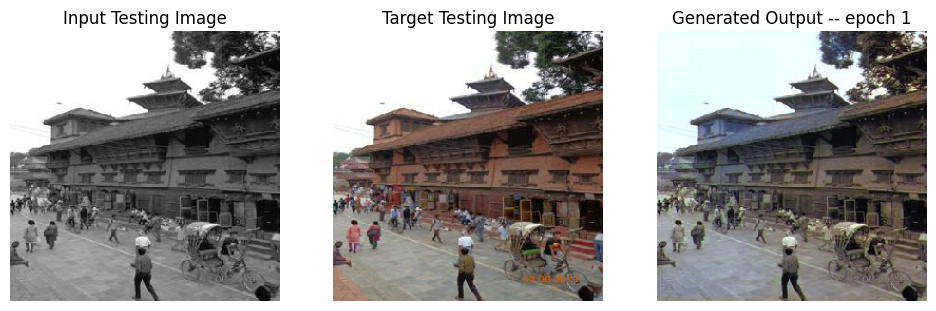

SSIM Score: 0.9235990047454834
PSNR Score: 24.453142166137695
LPIPS Score: 0.8457658886909485
Perceptual Loss: 0.007712629623711109
FID Score: 2.646550232117994
Epoch 1
Training Details
Generator-- total_loss:2.36191 gan_loss:0.78113 l1_loss:0.04065 perceptual_loss:0.00722 Discriminator-- total_loss:1.37753 real_loss:0.68490 generated_loss:0.69263 --- SSIM 0.92220 PSNR 23.51808 LPIPS 1.12794
Time taken for epoch 2 is 1021.9356486797333 sec
Number of iteration 980
Validation Details
Generator-- total_loss:3.36705 gan_loss:0.67181 l1_loss:0.07319  perceptual_loss:0.00999 Discriminator-- total_loss:1.36461 real_loss:0.74664 generated_loss:0.61797 --- SSIM 0.90277 PSNR 19.40696 LPIPS 1.47915
Time taken for epoch 2 is 1195.7577285766602 sec
Number of iteration 280
Epoch 2
Training Details
Generator-- total_loss:2.36567 gan_loss:0.78622 l1_loss:0.04074 perceptual_loss:0.00715 Discriminator-- total_loss:1.37627 real_loss:0.68332 generated_loss:0.69295 --- SSIM 0.92597 PSNR 23.42458 LPIPS 1.14

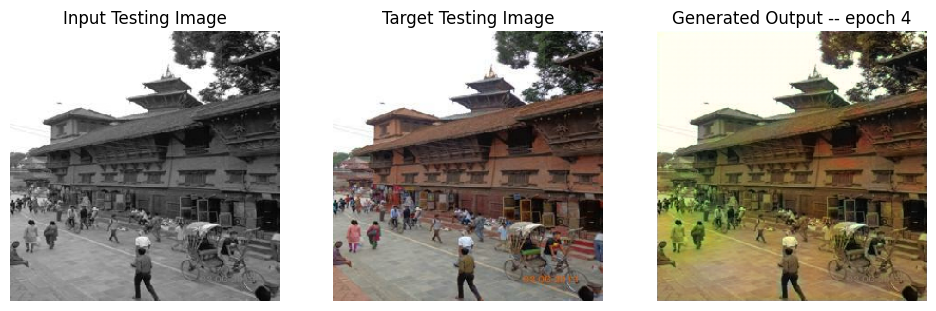

SSIM Score: 0.94711834192276
PSNR Score: 22.795621871948242
LPIPS Score: 0.9426494836807251
Perceptual Loss: 0.007390739396214485
FID Score: 2.3302673954880335
Epoch 4
Training Details
Generator-- total_loss:2.39196 gan_loss:0.87498 l1_loss:0.03903 perceptual_loss:0.00692 Discriminator-- total_loss:1.61643 real_loss:0.80342 generated_loss:0.81301 --- SSIM 0.93012 PSNR 23.75003 LPIPS 1.12740
Time taken for epoch 5 is 1025.8539309501648 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.68865 gan_loss:0.95281 l1_loss:0.04419  perceptual_loss:0.00821 Discriminator-- total_loss:1.42772 real_loss:0.51159 generated_loss:0.91613 --- SSIM 0.93054 PSNR 22.96201 LPIPS 1.21410
Time taken for epoch 5 is 1200.2126467227936 sec
Number of iteration 280
Epoch 5
Training Details
Generator-- total_loss:2.27966 gan_loss:0.75583 l1_loss:0.03917 perceptual_loss:0.00698 Discriminator-- total_loss:1.35924 real_loss:0.67414 generated_loss:0.68509 --- SSIM 0.92978 PSNR 23.64031 LPIPS 1.172

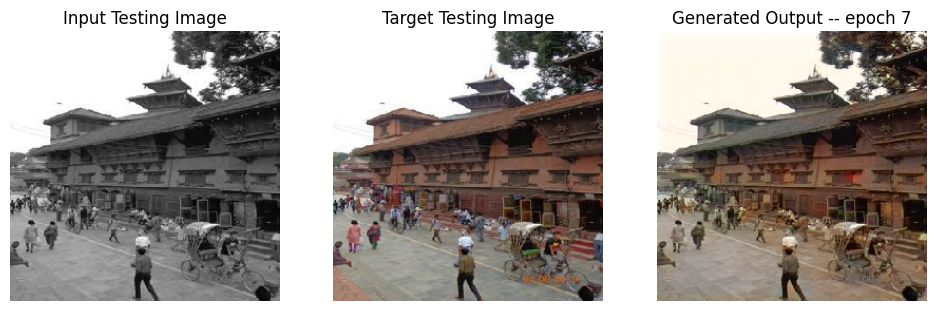

SSIM Score: 0.9602153897285461
PSNR Score: 26.758405685424805
LPIPS Score: 0.7977012395858765
Perceptual Loss: 0.0063790734857320786
FID Score: 1.7158276628503306
Epoch 7
Training Details
Generator-- total_loss:2.30904 gan_loss:0.77832 l1_loss:0.03912 perceptual_loss:0.00714 Discriminator-- total_loss:1.35780 real_loss:0.67397 generated_loss:0.68383 --- SSIM 0.92874 PSNR 23.64442 LPIPS 1.21264
Time taken for epoch 8 is 1049.0765755176544 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.89197 gan_loss:0.88715 l1_loss:0.05126  perceptual_loss:0.00934 Discriminator-- total_loss:1.57117 real_loss:0.81659 generated_loss:0.75458 --- SSIM 0.92132 PSNR 21.67417 LPIPS 1.45472
Time taken for epoch 8 is 1225.7782187461853 sec
Number of iteration 280
Epoch 8
Training Details
Generator-- total_loss:2.31851 gan_loss:0.78814 l1_loss:0.03898 perceptual_loss:0.00722 Discriminator-- total_loss:1.35481 real_loss:0.67239 generated_loss:0.68242 --- SSIM 0.92811 PSNR 23.68869 LPIPS 1.

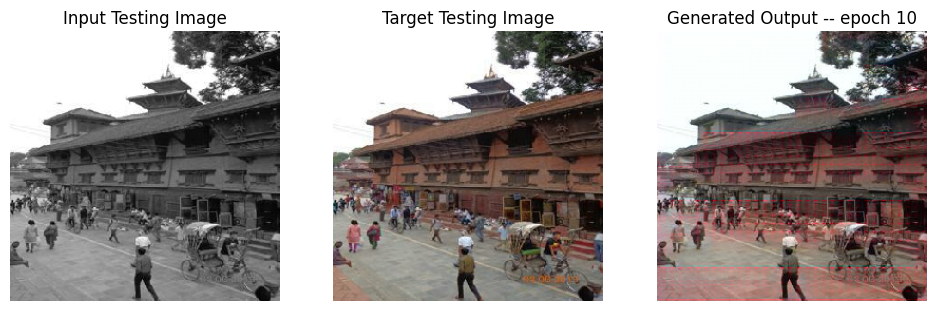

SSIM Score: 0.9119210243225098
PSNR Score: 25.785478591918945
LPIPS Score: 0.8714911937713623
Perceptual Loss: 0.005174172110855579
FID Score: 1.4803968843097706
Epoch 10
Training Details
Generator-- total_loss:1.85595 gan_loss:0.35137 l1_loss:0.03893 perceptual_loss:0.00673 Discriminator-- total_loss:2.27859 real_loss:1.40874 generated_loss:0.86984 --- SSIM 0.89666 PSNR 23.39024 LPIPS 1.19858
Time taken for epoch 11 is 885.871030330658 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.21409 gan_loss:0.42504 l1_loss:0.04552  perceptual_loss:0.00847 Discriminator-- total_loss:1.81658 real_loss:1.14287 generated_loss:0.67371 --- SSIM 0.89937 PSNR 22.44338 LPIPS 1.27955
Time taken for epoch 11 is 1058.4434769153595 sec
Number of iteration 280
Epoch 11
Training Details
Generator-- total_loss:11.14394 gan_loss:9.68350 l1_loss:0.03772 perceptual_loss:0.00658 Discriminator-- total_loss:0.25999 real_loss:0.13053 generated_loss:0.12947 --- SSIM 0.89437 PSNR 23.42471 LPIPS 

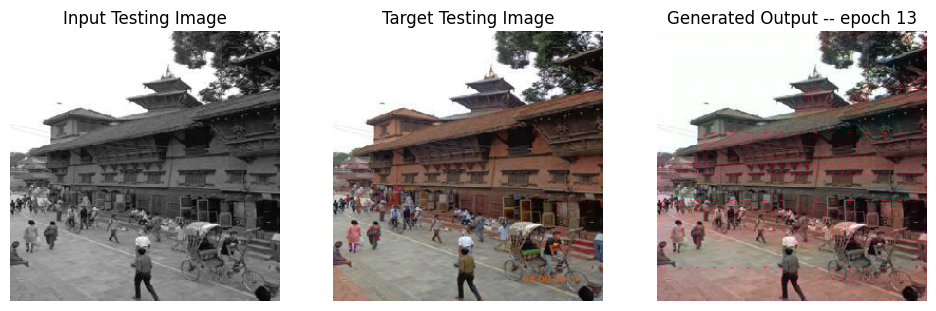

SSIM Score: 0.9061636328697205
PSNR Score: 24.95368766784668
LPIPS Score: 0.8956165909767151
Perceptual Loss: 0.005773557350039482
FID Score: 2.164638120383717
Epoch 13
Training Details
Generator-- total_loss:14.73193 gan_loss:13.26891 l1_loss:0.03781 perceptual_loss:0.00658 Discriminator-- total_loss:0.03414 real_loss:0.01300 generated_loss:0.02114 --- SSIM 0.89434 PSNR 23.41003 LPIPS 1.15491
Time taken for epoch 14 is 739.0505411624908 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.83382 gan_loss:1.15631 l1_loss:0.04276  perceptual_loss:0.00789 Discriminator-- total_loss:2.79820 real_loss:2.78712 generated_loss:0.01108 --- SSIM 0.89699 PSNR 22.76250 LPIPS 1.23038
Time taken for epoch 14 is 911.3456506729126 sec
Number of iteration 280
Epoch 14
Training Details
Generator-- total_loss:16.00944 gan_loss:14.54677 l1_loss:0.03779 perceptual_loss:0.00658 Discriminator-- total_loss:0.00058 real_loss:0.00029 generated_loss:0.00029 --- SSIM 0.89429 PSNR 23.41257 LPIPS

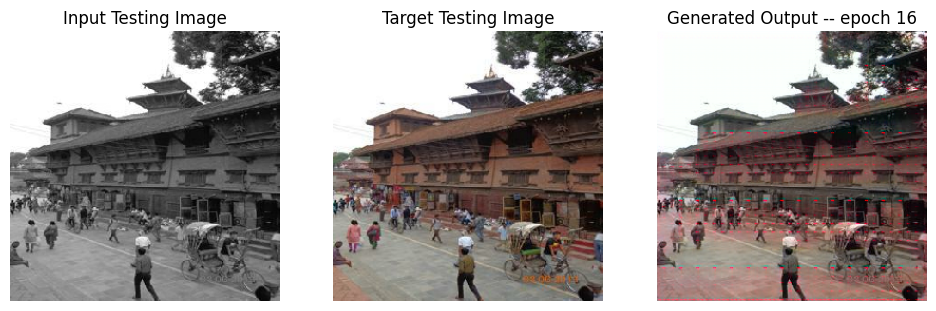

SSIM Score: 0.9065451622009277
PSNR Score: 24.98123550415039
LPIPS Score: 0.8951042890548706
Perceptual Loss: 0.0057949707843363285
FID Score: 2.1984013559986986
Epoch 16
Training Details
Generator-- total_loss:19.48206 gan_loss:18.02147 l1_loss:0.03774 perceptual_loss:0.00657 Discriminator-- total_loss:0.00007 real_loss:0.00003 generated_loss:0.00004 --- SSIM 0.89448 PSNR 23.42134 LPIPS 1.15409
Time taken for epoch 17 is 747.0567538738251 sec
Number of iteration 980
Validation Details
Generator-- total_loss:2.66315 gan_loss:0.98613 l1_loss:0.04275  perceptual_loss:0.00789 Discriminator-- total_loss:4.18494 real_loss:4.18140 generated_loss:0.00354 --- SSIM 0.89667 PSNR 22.75709 LPIPS 1.23053
Time taken for epoch 17 is 917.5558123588562 sec
Number of iteration 280
Epoch 17
Training Details
Generator-- total_loss:20.09743 gan_loss:18.63610 l1_loss:0.03777 perceptual_loss:0.00657 Discriminator-- total_loss:0.33057 real_loss:0.16125 generated_loss:0.16932 --- SSIM 0.89433 PSNR 23.41489 LPI

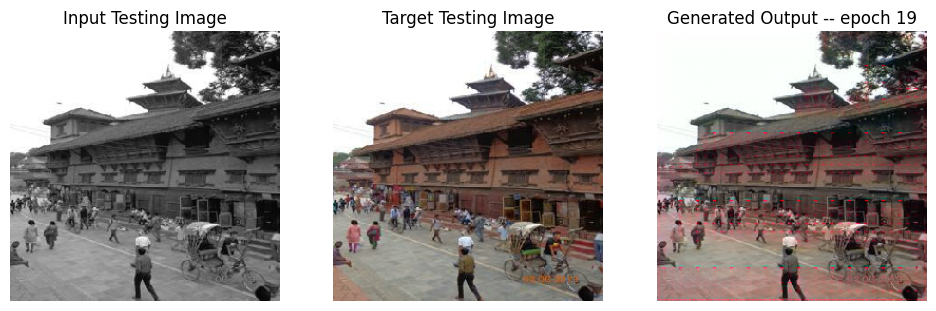

SSIM Score: 0.9070229530334473
PSNR Score: 24.99907875061035
LPIPS Score: 0.8938285112380981
Perceptual Loss: 0.005772099364548922
FID Score: 2.1893523992917845
Epoch 19
Training Details
Generator-- total_loss:16.02296 gan_loss:14.56127 l1_loss:0.03778 perceptual_loss:0.00657 Discriminator-- total_loss:0.00049 real_loss:0.00024 generated_loss:0.00025 --- SSIM 0.89446 PSNR 23.41867 LPIPS 1.15414
Time taken for epoch 20 is 747.120831489563 sec
Number of iteration 980
Validation Details
Generator-- total_loss:3.02350 gan_loss:1.34409 l1_loss:0.04282  perceptual_loss:0.00789 Discriminator-- total_loss:2.59108 real_loss:2.57690 generated_loss:0.01418 --- SSIM 0.89656 PSNR 22.74346 LPIPS 1.23242
Time taken for epoch 20 is 917.237429857254 sec
Number of iteration 280
Epoch 20
Training Details
Generator-- total_loss:17.41259 gan_loss:15.94931 l1_loss:0.03782 perceptual_loss:0.00657 Discriminator-- total_loss:0.05641 real_loss:0.03129 generated_loss:0.02512 --- SSIM 0.89435 PSNR 23.40710 LPIPS 

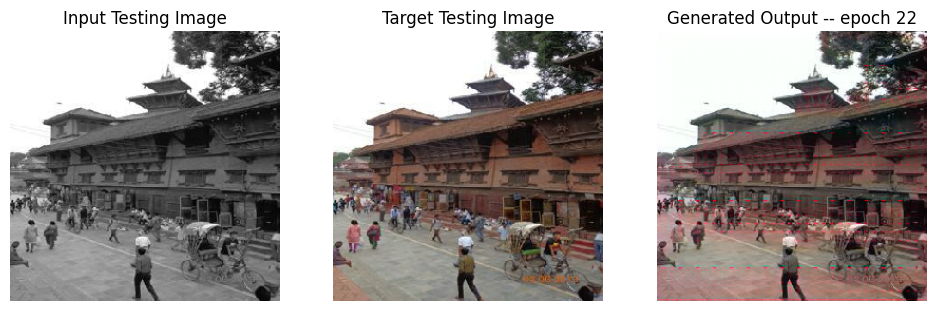

SSIM Score: 0.906785786151886
PSNR Score: 24.999156951904297
LPIPS Score: 0.8944171071052551
Perceptual Loss: 0.005789801944047213
FID Score: 2.1824133746417127
Epoch 22
Training Details
Generator-- total_loss:23.15434 gan_loss:21.69165 l1_loss:0.03781 perceptual_loss:0.00657 Discriminator-- total_loss:0.00015 real_loss:0.00007 generated_loss:0.00007 --- SSIM 0.89431 PSNR 23.41086 LPIPS 1.15421
Time taken for epoch 23 is 741.3200190067291 sec
Number of iteration 980
Validation Details
Generator-- total_loss:4.72989 gan_loss:3.05275 l1_loss:0.04275  perceptual_loss:0.00789 Discriminator-- total_loss:3.20181 real_loss:3.19032 generated_loss:0.01149 --- SSIM 0.89652 PSNR 22.76079 LPIPS 1.23029
Time taken for epoch 23 is 913.7777714729309 sec
Number of iteration 280
Epoch 23
Training Details
Generator-- total_loss:23.97372 gan_loss:22.51300 l1_loss:0.03775 perceptual_loss:0.00657 Discriminator-- total_loss:0.00012 real_loss:0.00006 generated_loss:0.00006 --- SSIM 0.89447 PSNR 23.41979 LPIP

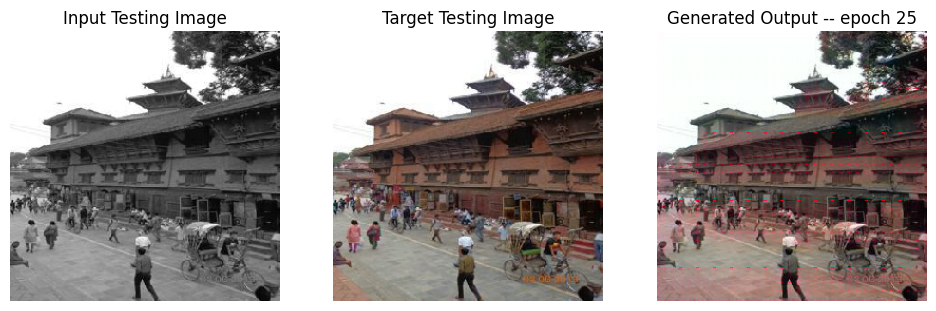

SSIM Score: 0.9067060351371765
PSNR Score: 24.996288299560547
LPIPS Score: 0.8941901326179504
Perceptual Loss: 0.005772967357188463
FID Score: 2.1716504045910128
Epoch 25
Training Details
Generator-- total_loss:25.63220 gan_loss:24.17218 l1_loss:0.03774 perceptual_loss:0.00656 Discriminator-- total_loss:0.00002 real_loss:0.00001 generated_loss:0.00001 --- SSIM 0.89446 PSNR 23.42221 LPIPS 1.15295
Time taken for epoch 26 is 728.6944868564606 sec
Number of iteration 980
Validation Details
Generator-- total_loss:3.99415 gan_loss:2.31479 l1_loss:0.04282  perceptual_loss:0.00790 Discriminator-- total_loss:3.87094 real_loss:3.86482 generated_loss:0.00612 --- SSIM 0.89648 PSNR 22.74133 LPIPS 1.23285
Time taken for epoch 26 is 900.8821065425873 sec
Number of iteration 280
Epoch 26
Training Details
Generator-- total_loss:26.72677 gan_loss:25.26655 l1_loss:0.03774 perceptual_loss:0.00656 Discriminator-- total_loss:0.17515 real_loss:0.09408 generated_loss:0.08107 --- SSIM 0.89451 PSNR 23.42147 LPI

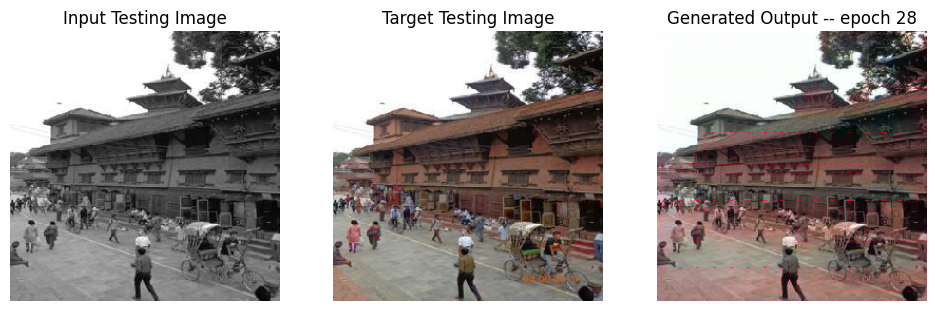

SSIM Score: 0.9068410992622375
PSNR Score: 25.00419807434082
LPIPS Score: 0.8937932848930359
Perceptual Loss: 0.005749105475842953
FID Score: 2.1892761383673034
Epoch 28
Training Details
Generator-- total_loss:26.97301 gan_loss:25.51370 l1_loss:0.03772 perceptual_loss:0.00655 Discriminator-- total_loss:0.00010 real_loss:0.00005 generated_loss:0.00006 --- SSIM 0.89461 PSNR 23.41870 LPIPS 1.15331
Time taken for epoch 29 is 728.8371486663818 sec
Number of iteration 980
Validation Details
Generator-- total_loss:6.13107 gan_loss:4.45332 l1_loss:0.04277  perceptual_loss:0.00789 Discriminator-- total_loss:2.39886 real_loss:2.37453 generated_loss:0.02433 --- SSIM 0.89656 PSNR 22.75527 LPIPS 1.23100
Time taken for epoch 29 is 899.5654437541962 sec
Number of iteration 280
Epoch 29
Training Details
Generator-- total_loss:27.41321 gan_loss:25.95318 l1_loss:0.03773 perceptual_loss:0.00656 Discriminator-- total_loss:0.00005 real_loss:0.00002 generated_loss:0.00003 --- SSIM 0.89448 PSNR 23.42111 LPIP

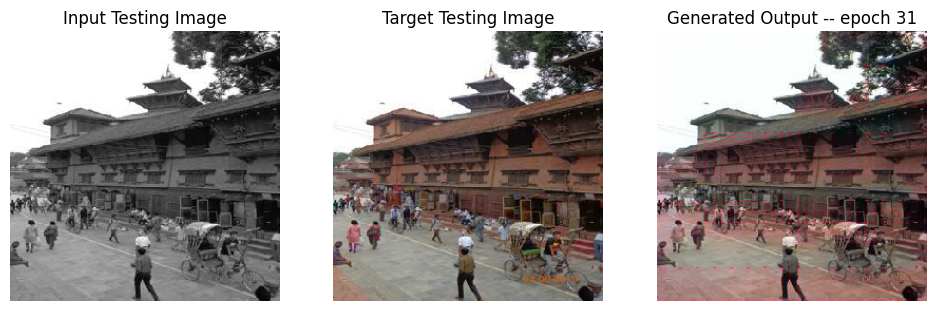

SSIM Score: 0.9070174694061279
PSNR Score: 25.025238037109375
LPIPS Score: 0.8936352729797363
Perceptual Loss: 0.005738670006394386
FID Score: 2.2015279241404184
Epoch 31
Training Details
Generator-- total_loss:28.53771 gan_loss:27.07651 l1_loss:0.03774 perceptual_loss:0.00658 Discriminator-- total_loss:0.00002 real_loss:0.00001 generated_loss:0.00001 --- SSIM 0.89452 PSNR 23.41948 LPIPS 1.15454
Time taken for epoch 32 is 730.3907177448273 sec
Number of iteration 980
Validation Details
Generator-- total_loss:7.05700 gan_loss:5.37870 l1_loss:0.04279  perceptual_loss:0.00789 Discriminator-- total_loss:2.51797 real_loss:2.50223 generated_loss:0.01575 --- SSIM 0.89656 PSNR 22.74850 LPIPS 1.23206
Time taken for epoch 32 is 902.2979934215546 sec
Number of iteration 280
Epoch 32
Training Details
Generator-- total_loss:29.22843 gan_loss:27.76770 l1_loss:0.03775 perceptual_loss:0.00656 Discriminator-- total_loss:0.00001 real_loss:0.00000 generated_loss:0.00000 --- SSIM 0.89444 PSNR 23.42094 LPI

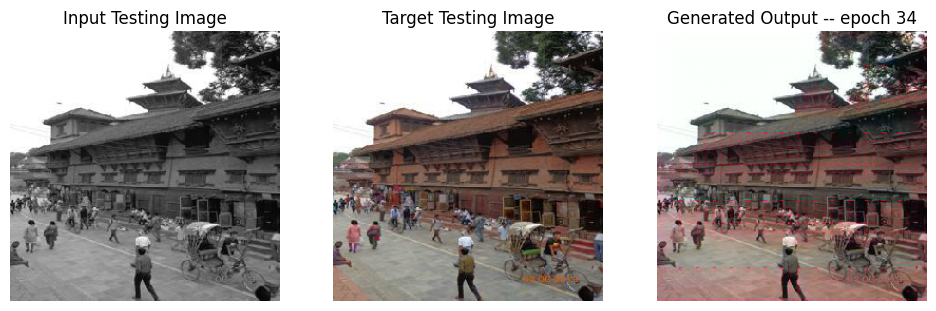

SSIM Score: 0.9067899584770203
PSNR Score: 24.997060775756836
LPIPS Score: 0.8939006328582764
Perceptual Loss: 0.00576583668589592
FID Score: 2.1950316922788353
Reduced generator learning rate to 0.0004500000213738531 at epoch 34
Epoch 34
Training Details
Generator-- total_loss:1.31264 gan_loss:0.03195 l1_loss:0.03236 perceptual_loss:0.00620 Discriminator-- total_loss:21.11220 real_loss:21.11220 generated_loss:0.00000 --- SSIM 0.94993 PSNR 25.39620 LPIPS 0.96412
Time taken for epoch 35 is 878.8797891139984 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.46253 gan_loss:0.00001 l1_loss:0.03690  perceptual_loss:0.00711 Discriminator-- total_loss:20.92724 real_loss:20.92701 generated_loss:0.00023 --- SSIM 0.94964 PSNR 24.76454 LPIPS 1.04198
Time taken for epoch 35 is 1050.9727718830109 sec
Number of iteration 280
Epoch 35
Training Details
Generator-- total_loss:1.25597 gan_loss:0.00023 l1_loss:0.03186 perceptual_loss:0.00600 Discriminator-- total_loss:20.64683 real_

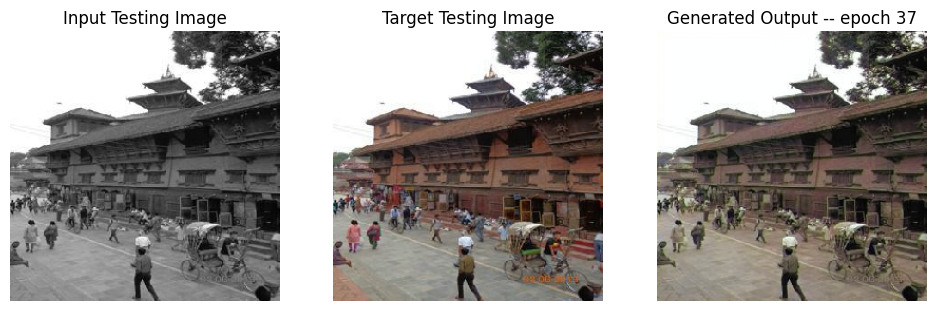

SSIM Score: 0.9749374389648438
PSNR Score: 30.24775505065918
LPIPS Score: 0.6628962159156799
Perceptual Loss: 0.005096154753118753
FID Score: 1.8417334933788985
Epoch 37
Training Details
Generator-- total_loss:1.24100 gan_loss:0.00014 l1_loss:0.03154 perceptual_loss:0.00590 Discriminator-- total_loss:20.61149 real_loss:20.61149 generated_loss:0.00000 --- SSIM 0.95484 PSNR 25.62853 LPIPS 0.92934
Time taken for epoch 38 is 880.6489210128784 sec
Number of iteration 980
Validation Details
Generator-- total_loss:1.45207 gan_loss:0.00001 l1_loss:0.03661  perceptual_loss:0.00708 Discriminator-- total_loss:20.92325 real_loss:20.92303 generated_loss:0.00022 --- SSIM 0.95226 PSNR 24.91318 LPIPS 0.99444
Time taken for epoch 38 is 1052.8504476547241 sec
Number of iteration 280
Epoch 38
Training Details
Generator-- total_loss:1.23487 gan_loss:0.00015 l1_loss:0.03140 perceptual_loss:0.00585 Discriminator-- total_loss:20.67785 real_loss:20.67785 generated_loss:0.00000 --- SSIM 0.95503 PSNR 25.66476 L

In [46]:
fit(train_dataset, epochs, validation_dataset, gen)

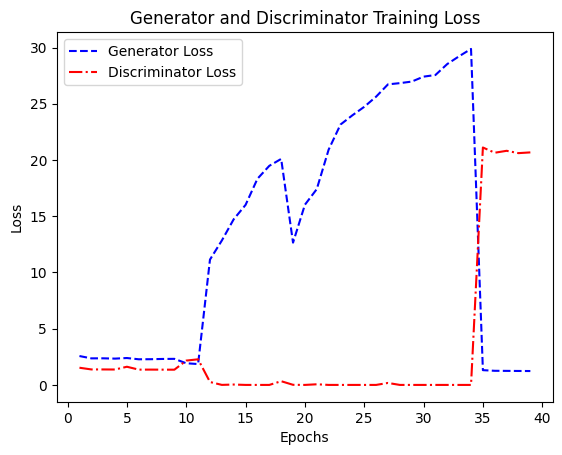

In [47]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, train_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/train_loss_plot_1.png')
plt.show()

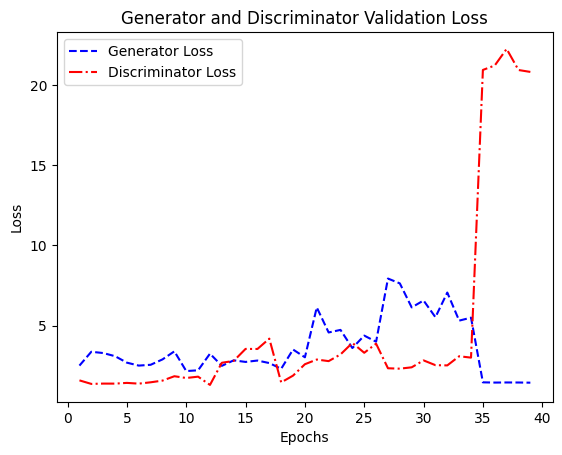

In [48]:
epochs = range(1, len(test_generator_losses) + 1)

plt.plot(epochs, test_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/test_loss_plot_1.png')
plt.show()

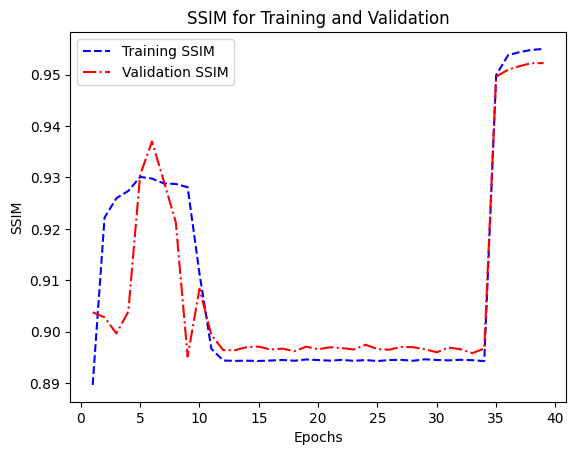

In [49]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_ssim, '--b', label='Training SSIM')
plt.plot(epochs, testing_ssim, '-.r', label='Validation SSIM')
plt.title('SSIM for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.savefig('/kaggle/working/SSIM_plot_1.png')
plt.show()

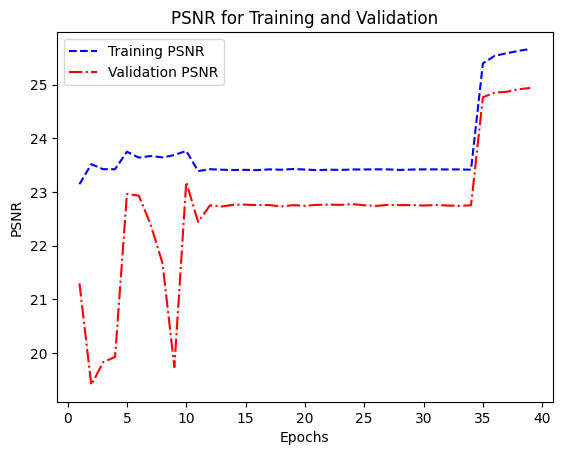

In [50]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_psnr, '--b', label='Training PSNR')
plt.plot(epochs, testing_psnr, '-.r', label='Validation PSNR')
plt.title('PSNR for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.savefig('/kaggle/working/PSNR_plot_1.png')
plt.show()

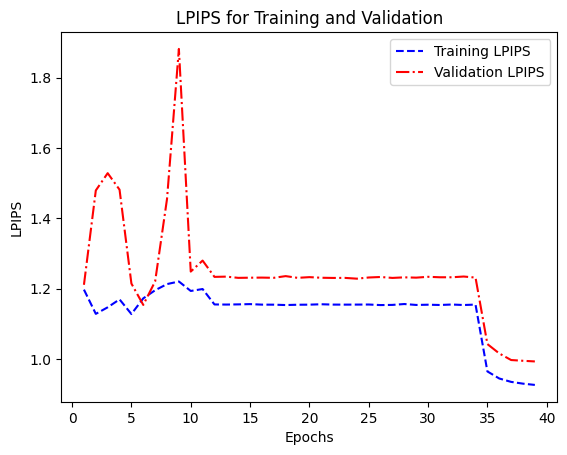

In [51]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_lpips, '--b', label='Training LPIPS')
plt.plot(epochs, testing_lpips, '-.r', label='Validation LPIPS')
plt.title('LPIPS for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('LPIPS')
plt.legend()
plt.savefig('/kaggle/working/LPIPS_plot_1.png')
plt.show()

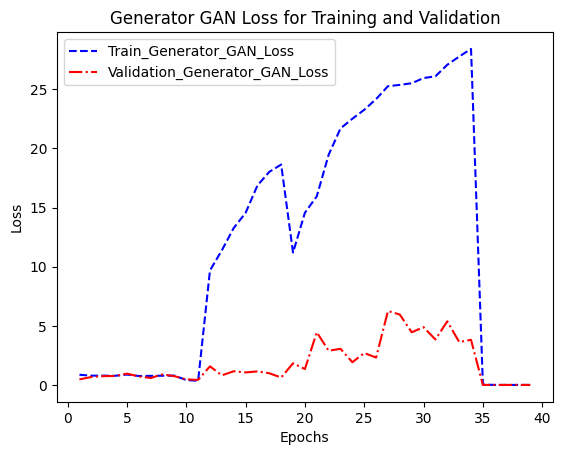

In [52]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_gan_losses, '--b', label='Train_Generator_GAN_Loss')
plt.plot(epochs, test_generator_gan_losses, '-.r', label='Validation_Generator_GAN_Loss')
plt.title('Generator GAN Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_GAN_plot_1.png')
plt.show()

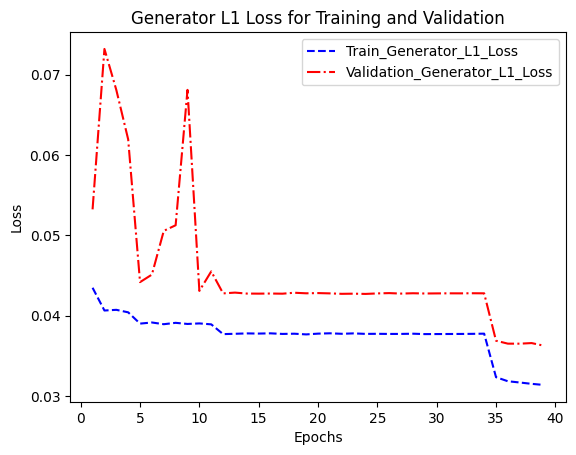

In [53]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_l1_losses, '--b', label='Train_Generator_L1_Loss')
plt.plot(epochs, test_generator_l1_losses, '-.r', label='Validation_Generator_L1_Loss')
plt.title('Generator L1 Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_L1_plot_1.png')
plt.show()

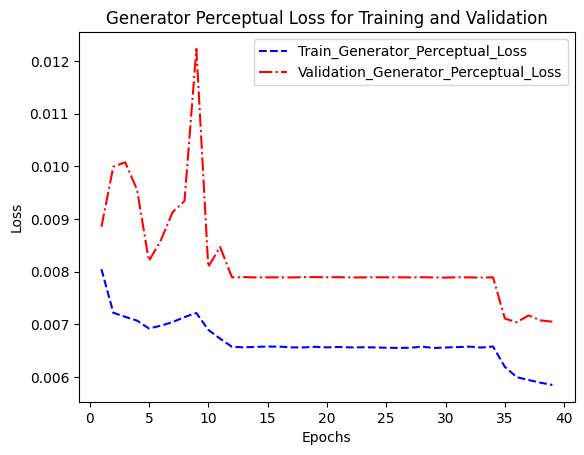

In [54]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_perceptual_losses, '--b', label='Train_Generator_Perceptual_Loss')
plt.plot(epochs, test_generator_perceptual_losses, '-.r', label='Validation_Generator_Perceptual_Loss')
plt.title('Generator Perceptual Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_Perceptual_plot_1.png')
plt.show()

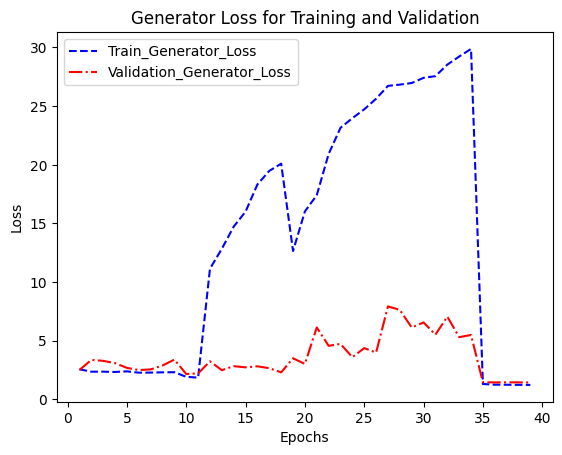

In [55]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Train_Generator_Loss')
plt.plot(epochs, test_generator_losses, '-.r', label='Validation_Generator_Loss')
plt.title('Generator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_plot_1.png')
plt.show()

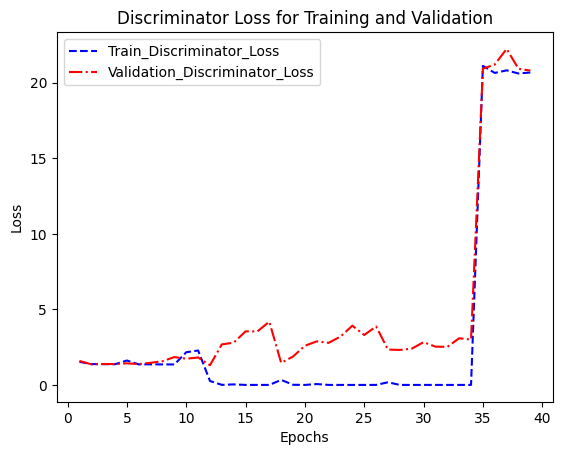

In [56]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_losses, '--b', label='Train_Discriminator_Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Validation_Discriminator_Loss')
plt.title('Discriminator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_plot_1.png')
plt.show()

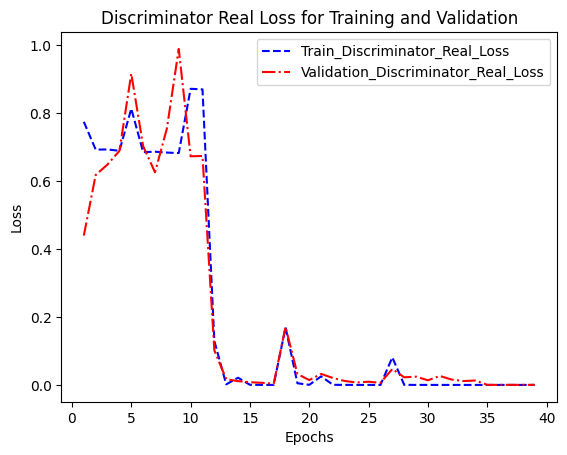

In [57]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_real_losses, '--b', label='Train_Discriminator_Real_Loss')
plt.plot(epochs, test_discriminator_real_losses, '-.r', label='Validation_Discriminator_Real_Loss')
plt.title('Discriminator Real Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Real_plot_1.png')
plt.show()

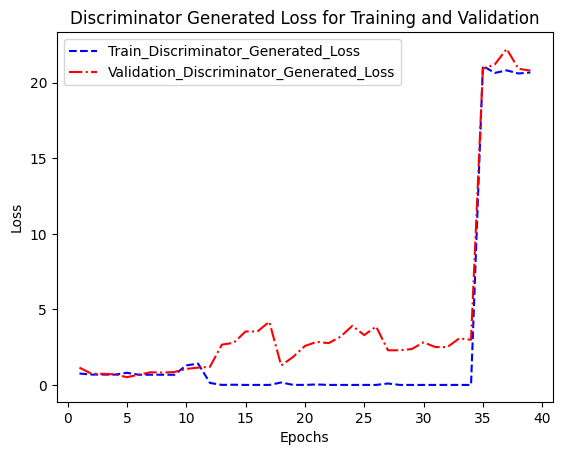

In [58]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_generated_losses, '--b', label='Train_Discriminator_Generated_Loss')
plt.plot(epochs, test_discriminator_generated_losses, '-.r', label='Validation_Discriminator_Generated_Loss')
plt.title('Discriminator Generated Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Generated_plot_1.png')
plt.show()

In [59]:
import csv
with open('/kaggle/working/dataJan20.csv','w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(all_records)

In [60]:
# Evaluation on testing data


each_epoch_test_lpips = []
each_epoch_test_psnr = []
each_epoch_test_ssim = []
each_epoch_test_fid = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_generator_l2_losses = []
each_epoch_test_generator_perceptual_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []

for n, (input_, target) in test_dataset.enumerate():
    test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips, test_fid = test_step(input_, target)

    each_epoch_test_generator_losses.append(test_gen_loss)
    each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
    each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
#             each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
    each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
    each_epoch_test_discriminator_losses.append(test_disc_loss)
    each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
    each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
    each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
    each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
    each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
    each_epoch_test_fid.append(test_fid)
    print(test_fid)

print("Testing Details")
print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  perceptual_loss:{:.5f} \nDiscriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- \nSSIM {:.5f} \nPSNR {:.5f} \nLPIPS {:.5f} \nFID Score: {:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips), np.mean(each_epoch_test_fid)))

1/1 [==============================] - 0s 214ms/step
0.5032264818379202
1/1 [==============================] - 0s 192ms/step
0.509446057096373
1/1 [==============================] - 0s 188ms/step
0.9781145891147941
1/1 [==============================] - 0s 200ms/step
0.5675046407538104
1/1 [==============================] - 0s 187ms/step
0.9814163435527683
1/1 [==============================] - 0s 185ms/step
0.4557936033538367
1/1 [==============================] - 0s 190ms/step
0.4000576625337769
1/1 [==============================] - 0s 182ms/step
0.9792153905321055
1/1 [==============================] - 0s 185ms/step
1.645089857432235
1/1 [==============================] - 0s 187ms/step
0.7791855895993558
1/1 [==============================] - 0s 187ms/step
0.7462343568032578
1/1 [==============================] - 0s 184ms/step
1.5745193675579745
1/1 [==============================] - 0s 181ms/step
0.46898345087743
1/1 [==============================] - 0s 180ms/step
0.5357888633643

In [61]:
os.mkdir('/kaggle/working/modelsFeb7')

In [62]:
gen.save('/kaggle/working/modelsFeb7/gen.h5')
gen.save_weights('/kaggle/working/modelsFeb7/gen_weight.keras')
disc.save('/kaggle/working/modelsFeb7/disc.h5')
disc.save_weights('/kaggle/working/modelsFeb7/disc_wweight.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode !=0:
        print("Unable to run zip command")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [64]:
import subprocess
from IPython.display import FileLink, display

In [65]:
download_file('/kaggle/working', 'outputFeb8')

/kaggle/working/outputFeb8.zip